In [21]:
import os.path as op 
import toblerone as tob 
from toblerone import estimators, projection 
import numpy as np 
import nibabel 
from scipy import sparse
from scipy.sparse import linalg
import tempfile 
from pdb import set_trace
from plotly.subplots import make_subplots 
import plotly.express as px
import plotly.graph_objects as go 
from surfplot import surf_fig, surf_mesh
import matplotlib.pyplot as plt 
import itertools
import multiprocessing as mp 
import copy as copy 
from subprocess import run 

data_path = 'svb_data'
spc_path = op.join(data_path, 'ref2.1.nii.gz')
t1_path = op.join(data_path, 'T1.nii.gz')
pv_path = op.join(data_path, 'pvs.nii.gz')
loadnii = lambda f: nibabel.load(f).get_fdata().reshape(-1)
loadfunc = lambda f: nibabel.load(f).darrays[0].data
plotsurf = tob.Surface(op.join('svb_data/fs_30k/lh.inflated.surf.gii'))

In [2]:
# import pyvista as pv 

# def to_polydata(surface):
#     tris = 3 * np.ones((surface.tris.shape[0], 4), dtype=np.int32)
#     tris[:,1:] = surface.tris
#     return pv.PolyData(surface.points, tris)

# p = pv.BackgroundPlotter(shape=(1, 3))
# p.subplot(0,0)
# p.add_mesh(to_polydata(plotsurf))
# p.subplot(0,1)
# p.add_mesh(to_polydata(L_hemi.inSurf))
# p.subplot(0,2)
# p.add_mesh(to_polydata(L_hemi.outSurf))
# p.show()

In [3]:
def imshow(data, spc, slice=None):
    if slice is None: 
        slice = (spc.size[2] // 2)
        
    fig = px.imshow(data.reshape(spc.size)[:,:,slice])
    fig.show()

In [6]:
# plt.spy(n2v); plt.show(); 
# plt.spy(v2n); plt.show()

## Volume -> surface -> volume projection

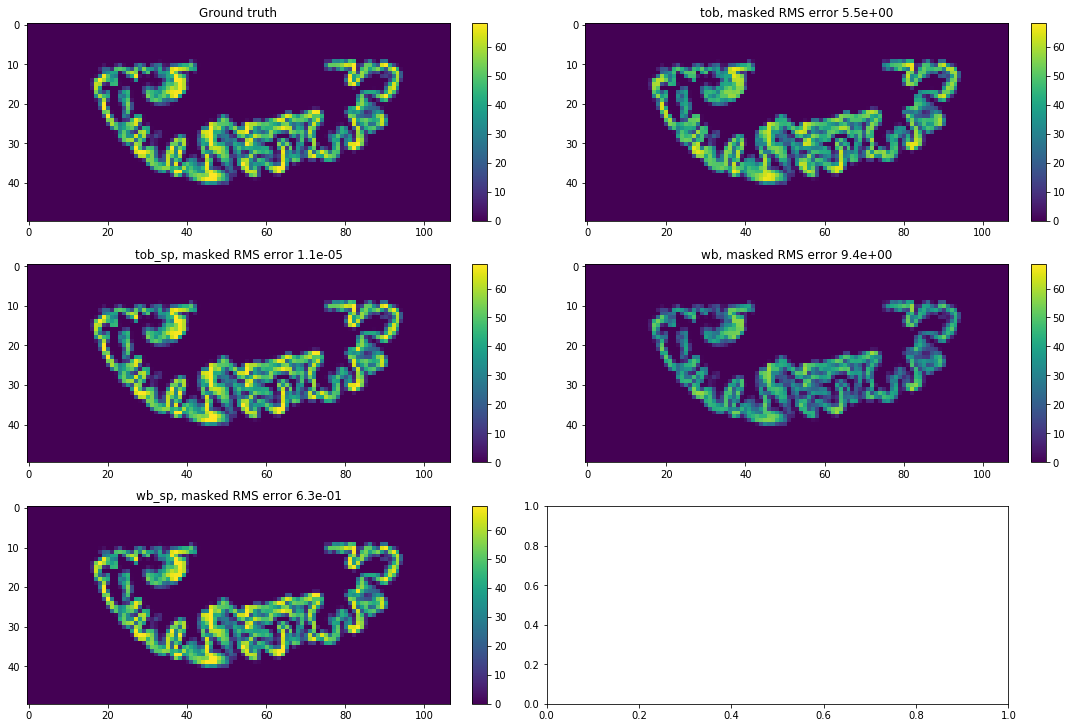

In [32]:
KEY = 'sine'
mask = (VTRUTH[KEY] > 0)

fig, axes = plt.subplots(3,2, constrained_layout=True)
fig.set_size_inches(15,10)

# Plot ground truth
gt = VTRUTH[KEY]
cmax = 0.95 * gt.max()
img = axes[0,0].imshow(gt.reshape(spc.size)[30:,:,45], vmin=0, vmax=cmax)
axes[0,0].set_title("Ground truth")
fig.colorbar(img, ax=axes[0,0])

# Plot comparators
for ax,(title,data) in zip(axes.flat[1:], v2s2v_results[KEY].items()):
    img = ax.imshow(data.reshape(spc.size)[30:,:,45], vmin=0, vmax=cmax)
    err = RMS(VTRUTH[KEY], data, mask)
    text = "%s, masked RMS error %2.1e" % (title, err)
    ax.set_title(text)
    fig.colorbar(img, ax=ax)
    

## Surface -> volume -> surface projection

In [20]:
struth = 60 * np.ones(L_hemi.inSurf.points.shape[0], dtype=np.float32)
# struth_pad = np.concatenate((struth, np.zeros(spc.size.prod())))

In [ ]:
# wb solution
s2v_wb = loadnii(op.join(data_path, 'comparisons/s2v_wb.nii.gz'))
s2v2s_wb = loadfunc(op.join(data_path, 'comparisons/s2v2s_wb.func.gii'))

In [25]:
def svs_test(struth, n2v_tob_mat, v2n_tob_mat, spc):
    
    # Tob solution 
    n2v_tob_mat = n2v_tob_mat[:,:L_hemi.inSurf.points.shape[0]]
    v2n_tob_mat = v2n_tob_mat[:L_hemi.inSurf.points.shape[0],:]
    s2v_tob = n2v_tob_mat.dot(struth)
    s2v2s_tob = v2n_tob_mat.dot(s2v_tob)
    s2v2s_tob_sp = linalg.lsqr(n2v_tob_mat, s2v_tob)[0]
    
    ins = op.abspath(op.join('svb_data/fs_30k/lh.white.surf.gii'))
    mids = op.abspath(op.join('svb_data/fs_30k/lh.mid.surf.gii'))
    outs = op.abspath(op.join('svb_data/fs_30k/lh.pial.surf.gii'))
    ref = op.abspath('svb_data/ref2.1.nii.gz')
    
    # WB solution
    s2v_wb = wb_n2v_method(struth, ins, mids, outs, ref)
    v2n_wb_mat = wb_v2n_method(s2v_wb, ins, mids, outs, spc)
    n2v_wb_mat = v2n_wb_mat.T
    n2v_wb_mat = projection.sparse_normalise(n2v_wb_mat, 1)
    s2v2s_wb = v2n_wb_mat.dot(s2v_wb)
#     raise RuntimeError("Need to renormalise the wb_matrix along other dimension, so don't normalise it earlier")
    s2v2s_wb_sp = linalg.lsqr(v2n_wb_mat.T, s2v_wb)[0]

    results = {
        'tob'    : s2v2s_tob,
        'tob_sp' : s2v2s_tob_sp,
        'wb'     : s2v2s_wb, 
        'wb_sp'  : s2v2s_wb_sp
    }

    return results 

svs_results = svs_test(struth, n2v, v2n, spc)

In [46]:
# specs = 6 * [[{'type': 'scene'}]]
# fig = make_subplots(6,1, specs=specs)
# fig.update_layout(width=800, height=2000)

# mesh = surf_mesh(plotsurf, struth/60)
# fig.add_trace(mesh, row=1, col=1)

# for X,(title,data) in zip(range(1,6), svs_results.items()):
#     mesh = surf_mesh(plotsurf,data/60)
#     fig.add_trace(mesh, row=X+1, col=1)
#     fig.data[0].showscale = False
    
# fig.show()

# for d,title in zip():

#     f = surf_fig(plotsurf, d)
#     err = RMS(struth, d)
#     text = "%s, masked RMS error %2.1e" % (title, err)
#     fig.update_layout(title_text=text)    
#     f.show()